## Practical 1:

### Imports

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import csv
import gc

### Data Download

In [2]:
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
zip_file = "ml-32m.zip"
extract_folder = "ml-32m"

print(f"Starting download of {url}...")

# Download only if not already downloaded
if not os.path.exists(zip_file) and not os.path.exists(extract_folder):
    !wget -q $url
    print("Download complete.")
else:
    print("File already downloaded or extracted. Skipping download.")

# Extract only if not already extracted
if not os.path.exists(extract_folder):
    print(f"Unzipping {zip_file}...")
    !unzip -q $zip_file
    print(f"Successfully unzipped to '{extract_folder}' folder.")
else:
    print(f"'{extract_folder}' already exists. Skipping unzip.")

# List contents
if os.path.exists(extract_folder):
    print(f"\nContents of {extract_folder}:")
    !ls -l $extract_folder
else:
    print(f"Error: Folder '{extract_folder}' not found after extraction.")

# Clean up the zip file if it still exists
if os.path.exists(zip_file):
    print(f"\nCleaning up {zip_file}...")
    os.remove(zip_file)
    print("Zip file removed.")

Starting download of https://files.grouplens.org/datasets/movielens/ml-32m.zip...
File already downloaded or extracted. Skipping download.
'ml-32m' already exists. Skipping unzip.

Contents of ml-32m:
total 934187
-rw-rw-r-- 1 hassanh people       178 Oct 13  2023 checksums.txt
-rw-rw-r-- 1 hassanh people   1950748 Oct 13  2023 links.csv
-rw-rw-r-- 1 hassanh people   4242926 Oct 13  2023 movies.csv
-rw-rw-r-- 1 hassanh people 877076222 Oct 13  2023 ratings.csv
-rw-rw-r-- 1 hassanh people      9227 Oct 13  2023 README.txt
-rw-rw-r-- 1 hassanh people  72353890 Oct 13  2023 tags.csv


### Data Structure Class

In [3]:
class RatingsData:
    def __init__(self, file_path):
        self.file_path = file_path

        # Mappings
        self.user_id_to_idx = {}
        self.idx_to_user_id = []
        self.movie_id_to_idx = {}
        self.idx_to_movie_id = []

        # Data
        self.data_by_user = []
        self.data_by_movie = []

    def load(self):
        user_set = set()
        movie_set = set()

        # First pass: collect all unique IDs
        with open(self.file_path, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # skip header
            for row in reader:
                user_set.add(int(row[0]))
                movie_set.add(int(row[1]))

        # creating mappings
        self.idx_to_user_id = sorted(list(user_set))
        self.idx_to_movie_id =sorted(list(movie_set))

        self.user_id_to_idx = {uid: i for i, uid in enumerate(self.idx_to_user_id)}
        self.movie_id_to_idx = {mid: i for i, mid in enumerate(self.idx_to_movie_id)}

        # initializing data lists
        self.data_by_user = [[] for _ in range(len(self.idx_to_user_id))]
        self.data_by_movie = [[] for _ in range(len(self.idx_to_movie_id))]

        # fill ratings
        with open(self.file_path, 'r') as f:
            reader = csv.reader(f)
            next(reader) # skip header
            for row in reader:
                user_id = int(row[0])
                movie_id = int(row[1])
                rating = float(row[2])

                u_idx = self.user_id_to_idx[user_id]
                m_idx = self.movie_id_to_idx[movie_id]

                self.data_by_user[u_idx].append((movie_id, rating))
                self.data_by_movie[m_idx].append((user_id, rating))


    def get_user_ratings(self, user_id):
        u_idx = self.user_id_to_idx[user_id]
        return self.data_by_user[u_idx]

    def get_movie_ratings(self, movie_id):
        m_idx = self.movie_id_to_idx[movie_id]
        return self.data_by_movie[m_idx]

    def num_users(self):
        return len(self.idx_to_user_id)

    def num_movies(self):
        return len(self.idx_to_movie_id)


### Load Data

In [4]:
file_path = "ml-32m/ratings.csv"
data = RatingsData(file_path)
data.load()

In [ ]:
data.get_movie_ratings(296)

In [ ]:
data.get_user_ratings(296)

### Exploratory Data Analysis (EDA)

In [ ]:
def plot_rating_distribution(ratings_data):
    """
    Plot rating distribution with bars centered on the actual rating values.
    ratings_data: instance of RatingsData after load()
    """
    # Collect all ratings into a NumPy array
    all_ratings = []
    for user_ratings in ratings_data.data_by_user:
        for _, rating in user_ratings:
            all_ratings.append(rating)
    all_ratings = np.array(all_ratings)

    # Define rating values (centers)
    rating_values = np.arange(0.5, 5.1, 0.5)  # 0.5, 1.0, ..., 5.0
    counts = np.array([np.sum(all_ratings == r) for r in rating_values])

    # Plot
    plt.figure(figsize=(8,5))
    plt.bar(rating_values, counts, width=0.4, color='skyblue', edgecolor='black')
    plt.xlabel("Rating")
    plt.ylabel("Number of Ratings")
    plt.title("Rating Distribution (Centered)")
    plt.xticks(rating_values)
    plt.show()


In [ ]:
plot_rating_distribution(data)

In [ ]:
def plot_avg_rating_per_user(ratings_data):
    """
    Plot the distribution of average ratings per user.
    ratings_data: instance of RatingsData after load()
    """
    # Compute average rating per user
    avg_ratings = []
    for user_ratings in ratings_data.data_by_user:
        if len(user_ratings) > 0:
            ratings = [r for _, r in user_ratings]
            avg_ratings.append(np.mean(ratings))
    avg_ratings = np.array(avg_ratings)

    # Plot histogram
    plt.figure(figsize=(8,5))
    bins = np.arange(0.5, 5.1, 0.25)  # finer bins for averages
    plt.hist(avg_ratings, bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel("Average Rating per User")
    plt.ylabel("Number of Users")
    plt.title("Distribution of Average Ratings per User")
    plt.xticks(np.arange(0.5, 5.1, 0.5))
    plt.show()


In [ ]:
plot_avg_rating_per_user(data)

In [ ]:
def plot_frequency_vs_degree(ratings_data):
    """
    Log-log plot of frequency vs degree for movies and users.
    Degree = number of ratings per movie/user.
    Frequency = how many movies/users have that degree.
    """
    # Movies
    movie_degrees = np.array([len(r) for r in ratings_data.data_by_movie])
    movie_deg_vals, movie_counts = np.unique(movie_degrees, return_counts=True)

    # Users
    user_degrees = np.array([len(r) for r in ratings_data.data_by_user])
    user_deg_vals, user_counts = np.unique(user_degrees, return_counts=True)

    # Plot
    plt.figure(figsize=(8,6))
    plt.loglog(movie_deg_vals, movie_counts, marker='.', linestyle='none', color='blue', label='Movies')
    plt.loglog(user_deg_vals, user_counts, marker='.', linestyle='none', color='orange', label='Users')

    plt.xlabel("Degree (Number of Ratings)")
    plt.ylabel("Frequency")
    plt.title("Frequency vs Degree (Movies & Users) - Log-Log")
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()
    plt.show()

In [ ]:
plot_frequency_vs_degree(data)

## Practical 2:
- download movielens dataset with 100k items for testing with faster loading time
- split into training and test (90% 10%)
- test the algorithm

### Download 100k Dataset

In [ ]:
# from google.colab import drive

# # Mount your Drive
# drive.mount('/content/drive')

# # Path to your uploaded file
# file_path = "/content/drive/MyDrive/data/ratings_100k.csv"

# data_test = RatingsData(file_path)
# data_test.load()

ModuleNotFoundError: No module named 'google'

### Train/Test Split

In [ ]:
# Get the total number of users and movies from the dataset
n_users = len(data_test.data_by_user)
n_movies = len(data_test.data_by_movie)

# Initialize empty lists to store train/test splits
# Each user/movie will have separate lists for training and testing ratings
data_by_user_train = [[] for _ in range(n_users)]
data_by_user_test  = [[] for _ in range(n_users)]
data_by_movie_train = [[] for _ in range(n_movies)]
data_by_movie_test  = [[] for _ in range(n_movies)]

# First pass: Split ratings by user (90% train, 10% test)
# Loop through each user and randomly assign their ratings to train or test
for i in range(n_users):
  ratings = data_test.data_by_user[i]
  for movie_id, rating in ratings:
    # 90% probability of going to training set
    if np.random.rand() < 0.9:
      data_by_user_train[i].append((movie_id, rating))
    else:
      # 10% probability of going to test set
      data_by_user_test[i].append((movie_id, rating))

# Second pass: Reorganize the split data by movie
# This creates movie-indexed versions of the train/test splits
for i in range(n_users):
    # Get the actual user ID from the index
    user_id = data_test.idx_to_user_id[i]

    # Add this user's training ratings to the movie-indexed training data
    for movie_id, rating in data_by_user_train[i]:
        m_idx = data_test.movie_id_to_idx[movie_id]
        data_by_movie_train[m_idx].append((user_id, rating))

    # Add this user's test ratings to the movie-indexed test data
    for movie_id, rating in data_by_user_test[i]:
        m_idx = data_test.movie_id_to_idx[movie_id]
        data_by_movie_test[m_idx].append((user_id, rating))

### Confirming Split

In [ ]:
print(f"number of items in users train set: {len(data_by_user_train)}")
print(f"number of items in users test set: {len(data_by_user_test)}")


non_empty_users_train = sum(1 for u in data_by_user_train if len(u) > 0)
non_empty_users_test = sum(1 for u in data_by_user_test if len(u) > 0)

print(f"Number of users with ratings in train set: {non_empty_users_train}")
print(f"Number of users with ratings in test set: {non_empty_users_test}")

print("------------------------------------------------------------------")

print(f"number of items in movies train set: {len(data_by_movie_train)}")
print(f"number of items in movies test set: {len(data_by_movie_test)}")

non_empty_movies_train = sum(1 for u in data_by_movie_train if len(u) > 0)
non_empty_movies_test = sum(1 for u in data_by_movie_test if len(u) > 0)

print(f"Number of movies with ratings in train set: {non_empty_movies_train}")
print(f"Number of movies with ratings in test set: {non_empty_movies_test}")

### Training with Bias Only

In [ ]:
M = n_users
N = n_movies

lambd = 0.01    # update weight factor
gamma = 0.01  # regularisation term for biases
num_iters = 20

# Initialise user & item biases lists
user_biases = np.zeros((M))
item_biases = np.zeros((N))

# Calculate Global Mean
global_mean = 0
total_ratings = 0
for m in range(M):
    for (movie_idx, r) in data_by_user_train[m]:
        global_mean += r
        total_ratings += 1
global_mean /= total_ratings

# For plotting
loss_history = []
rmse_train_history = []
rmse_test_history  = []

# Start ALS loop
for iter in range(num_iters):
    # Update user biases
    for m in range(M):
        bias = 0 # initialise bias at 0
        count = 0 # to keep track of number of ratings in each user list
        for (movie_id, r) in data_by_user_train[m]:
            movie_idx = data_test.movie_id_to_idx[movie_id]
            bias += lambd * (r - global_mean - item_biases[movie_idx]) # sum of residuals multiplied by lambda
            # bias += lambd * (r - item_biases[movie_idx]) # sum of residuals multiplied by lambda
            count += 1                                                 # to keep track of how many ratings the user has

        user_biases[m] = bias / (lambd * count + gamma) # gamma regularises the bias for users with few ratings

    # Update item biases
    for n in range(N):
        bias = 0
        count = 0
        for (user_id, r) in data_by_movie_train[n]:
            user_idx = data_test.user_id_to_idx[user_id]
            bias += lambd * (r - global_mean - user_biases[user_idx])
            # bias += lambd * (r - user_biases[user_idx])
            count += 1

        item_biases[n] = bias / (lambd * count + gamma)

    # Training loss & RMSE
    squared_error = 0
    count = 0
    for m in range(M):
        for movie_id, r in data_by_user_train[m]:
            # We assume predicted rating = global_mean + user_bias + item_bias
            movie_idx = data_test.movie_id_to_idx[movie_id]
            pred = global_mean + user_biases[m] + item_biases[movie_idx]
            # pred = user_biases[m] + item_biases[movie_idx]
            squared_error += (r - pred) ** 2
            count += 1

    reg_term = lambd * (np.sum(user_biases**2) + np.sum(item_biases**2))

    rmse_train = np.sqrt(squared_error / count)
    total_loss = squared_error + reg_term
    rmse_train_history.append(rmse_train)
    loss_history.append(total_loss)

    # Compute test RMSE
    squared_error_test = 0
    count_test = 0
    for m in range(M):
        for movie_id, r in data_by_user_test[m]:
            movie_idx = data_test.movie_id_to_idx[movie_id]
            pred = user_biases[m] + item_biases[movie_idx]
            squared_error_test += (r - pred) ** 2
            count_test += 1
    rmse_test = np.sqrt(squared_error_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"Loss = {squared_error:.2f}")

# --- Plot training loss ---
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")

# --- Plot training RMSE ---
plt.subplot(1,3,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

## Practical 3:

### 1. Prediction Formula

The predicted rating ($\hat{r}_{mn}$) for a user $m$ and item $n$.

$$
\hat{r}_{mn} = \mathbf{u}_m^T \mathbf{v}_n + b_m^u + b_n^i
$$

* Corresponds to the `pred` variable in the code: `pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])`

### 2. Loss Function (Negative Log Likelihood)

The objective function to minimize.

$$
\text{NLL} = -L = \frac{\lambda}{2} \sum_{(m,n) \in \Omega} (r_{mn} - \hat{r}_{mn})^2 + \frac{\tau}{2} \left( \sum_{m} ||\mathbf{u}_m||^2 + \sum_{n} ||\mathbf{v}_n||^2 \right) + \frac{\gamma}{2} \left( \sum_{m} (b_m^u)^2 + \sum_{n} (b_n^i)^2 \right)
$$

* Calculated in the code as:
```python
  nll = (lambda_reg/2) * squared_error + (tau/2) * reg_factors + (gamma/2) * reg_bias
```

### 3. RMSE (Root Mean Squared Error)

The error metric used to evaluate the model.

$$
\text{RMSE} = \sqrt{\frac{1}{|\Omega|} \sum_{(m,n) \in \Omega} (r_{mn} - \hat{r}_{mn})^2}
$$

* Calculated as: `rmse_train = np.sqrt(squared_error / count)`

### 4. ALS Updates

The equations solved in the alternating least squares procedure.

#### User Bias ($b_m^u$)

$$
b_m^u \leftarrow \frac{\lambda \sum_{n \in \Omega_m} (r_{mn} - b_n^i - \mathbf{u}_m^T \mathbf{v}_n)}{\lambda |\Omega_m| + \gamma}
$$

* Code:
```python
  user_biases[m] = bias_sum / (lambda_reg * len(items) + gamma)
```

#### User Latent Factors ($\mathbf{u}_m$)

$$
\mathbf{u}_m \leftarrow \left( \lambda \sum_{n \in \Omega_m} \mathbf{v}_n \mathbf{v}_n^T + \tau I \right)^{-1} \left( \lambda \sum_{n \in \Omega_m} \mathbf{v}_n (r_{mn} - b_m^u - b_n^i) \right)
$$

* Code:
```python
  A = lambda_reg * sum of outer products + tau * I
  b = lambda_reg * sum of weighted item vectors
  U[m] = np.linalg.solve(A, b)
```

#### Item Bias ($b_n^i$)

$$
b_n^i \leftarrow \frac{\lambda \sum_{m \in \Omega_n} (r_{mn} - b_m^u - \mathbf{u}_m^T \mathbf{v}_n)}{\lambda |\Omega_n| + \gamma}
$$

* Code:
```python
  item_biases[n] = bias_sum / (lambda_reg * len(users) + gamma)
```

#### Item Latent Factors ($\mathbf{v}_n$)

$$
\mathbf{v}_n \leftarrow \left( \lambda \sum_{m \in \Omega_n} \mathbf{u}_m \mathbf{u}_m^T + \tau I \right)^{-1} \left( \lambda \sum_{m \in \Omega_n} \mathbf{u}_m (r_{mn} - b_m^u - b_n^i) \right)
$$

* Code:
```python
  A = lambda_reg * sum of outer products + tau * I
  b = lambda_reg * sum of weighted user vectors
  V[n] = np.linalg.solve(A, b)
```

---

#### Variables
* $r_{mn}$: True rating for user $m$ and item $n$
* $\hat{r}_{mn}$: Predicted rating
* $\mathbf{u}_m \in \mathbb{R}^K$: User latent factor vector (code: `U[m]`)
* $\mathbf{v}_n \in \mathbb{R}^K$: Item latent factor vector (code: `V[n]`)
* $b_m^u$: User bias (code: `user_biases[m]`)
* $b_n^i$: Item bias (code: `item_biases[n]`)
* $\lambda$: Data term regularization (code: `lambda_reg`)
* $\tau$: Latent factor regularization (code: `tau`)
* $\gamma$: Bias regularization (code: `gamma`)
* $K$: Number of latent factors (code: `K = 15`)
* $\Omega_m$: Set of items rated by user $m$
* $\Omega_n$: Set of users who rated item $n$
* $I$: Identity matrix of size $K \times K$

In [ ]:
# Hyperparameters
K = 25               # Number of latent factors
num_iters = 15       # Number of ALS iterations
lambda_reg = 0.001   # Regularization for latent factors (U, V)
tau = 0.05           # Regularization term for user/item vectors
gamma = 0.001        # Regularization for biases


M = len(data_by_user_train)   # Number of users
N = len(data_by_movie_train)  # Number of movies

# Calculate global mean
all_ratings = []
for m in range(M):
    for movie_id, r in data_by_user_train[m]:
        all_ratings.append(r)
global_mean = np.mean(all_ratings)

# Initialize biases and latent factors
user_biases = np.zeros(M)
item_biases = np.zeros(N)
U = 0.1 * np.random.randn(M, K)   # User latent factors
V = 0.1 * np.random.randn(N, K)   # Item latent factors

# For plotting
nll_history = []        # Negative log likelihood
rmse_train_history = []
rmse_test_history = []

# ALS Loop
for iter in range(num_iters):

    # Update user biases and latent vectors
    for m in range(M):
        items = data_by_user_train[m]
        if not items:
            continue

        # Update user bias
        bias_sum = 0
        for movie_id, r in items:
            n = data_test.movie_id_to_idx[movie_id]
            pred = global_mean + item_biases[n] + np.dot(U[m], V[n])
            residual = r - pred
            bias_sum += lambda_reg * residual
        user_biases[m] = bias_sum / (lambda_reg * len(items) + gamma)

        # Update user latent vector
        A = np.zeros((K, K))
        b = np.zeros(K)

        for movie_id, r in items:
            n = data_test.movie_id_to_idx[movie_id]
            residual = r - global_mean - user_biases[m] - item_biases[n]

            A += lambda_reg * np.outer(V[n], V[n])
            b += lambda_reg * residual * V[n]

        A += tau * np.eye(K)
        U[m] = np.linalg.solve(A, b)

    # Update item biases and latent vectors
    for n in range(N):
        users = data_by_movie_train[n]
        if not users:
            continue

        # Update item bias
        bias_sum = 0
        for user_id, r in users:
            m_idx = data_test.user_id_to_idx[user_id]
            pred = global_mean + user_biases[m_idx] + np.dot(U[m_idx], V[n])
            residual = r - pred
            bias_sum += lambda_reg * residual
        item_biases[n] = bias_sum / (lambda_reg * len(users) + gamma)

        # Update item latent vector
        A = np.zeros((K, K))
        b = np.zeros(K)

        for user_id, r in users:
            m_idx = data_test.user_id_to_idx[user_id]
            residual = r - global_mean - user_biases[m_idx] - item_biases[n]

            A += lambda_reg * np.outer(U[m_idx], U[m_idx])
            b += lambda_reg * residual * U[m_idx]

        A += tau * np.eye(K)
        V[n] = np.linalg.solve(A, b)

    # Compute negative log likelihood (training)
    squared_error = 0
    count = 0
    for m in range(M):
        for movie_id, r in data_by_user_train[m]:
            n = data_test.movie_id_to_idx[movie_id]
            pred = global_mean + user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error += (r - pred) ** 2
            count += 1

    # Regularization terms
    reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
    reg_factors = np.sum(U ** 2) + np.sum(V ** 2)

    # Log likelihood formula from slides
    log_likelihood = -(lambda_reg / 2) * squared_error - (tau / 2) * reg_factors - (gamma / 2) * reg_bias

    # Negative log likelihood (negate to get NLL)
    nll = -log_likelihood
    nll_history.append(nll)

    # Training RMSE
    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)

    # Compute test RMSE
    squared_error_test = 0
    count_test = 0
    for m in range(M):
        for movie_id, r in data_by_user_test[m]:
            n = data_test.movie_id_to_idx[movie_id]
            pred = global_mean + user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error_test += (r - pred) ** 2
            count_test += 1
    rmse_test = np.sqrt(squared_error_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"NLL = {nll:.2f}")

# Plot results
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(nll_history, marker='o', color='purple')
plt.title("Negative Log Likelihood (Training)")
plt.xlabel("Iteration")
plt.ylabel("Negative Log Likelihood")

plt.subplot(1,3,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.title("Training RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

### Finding best hyperparameters via Grid Search

In [ ]:
from itertools import product

# Fixed K value
K = 25  # Number of latent factors

# Values to search over
lambda_reg_values = [0.0005, 0.001, 0.005]        # Regularization for likelihood
tau_values = [0.03, 0.05, 0.1]                    # Regularization for latent factors
gamma_values = [0.0005, 0.001, 0.005]             # Regularization for biases

num_iters = 10  # Number of iterations for search

# Calculate total combinations
total_combinations = len(lambda_reg_values) * len(tau_values) * len(gamma_values)

print("\n" + "="*70)
print("GRID SEARCH FOR BEST HYPERPARAMETERS - ALS WITH LATENT FACTORS")
print("="*70)
print(f"K (fixed): {K}")
print(f"lambda_reg values: {lambda_reg_values}")
print(f"tau values: {tau_values}")
print(f"gamma values: {gamma_values}")
print(f"Iterations per combination: {num_iters}")
print(f"Total combinations to test: {total_combinations}")
print("="*70 + "\n")

# Dataset dimensions
M = len(data_by_user_train)   # Number of users
N = len(data_by_movie_train)  # Number of movies

# SEARCH LOOP
# Store results for each hyperparameter combination
grid_search_results = []
combination_num = 0

# Iterate over all combinations of hyperparameters
for lambda_reg, tau, gamma in product(lambda_reg_values, tau_values, gamma_values):
    combination_num += 1

    print(f"\n{'='*70}")
    print(f"COMBINATION {combination_num}/{total_combinations}")
    print(f"lambda={lambda_reg}, tau={tau}, gamma={gamma}")
    print(f"{'='*70}")

    # Initialize biases and latent factors
    user_biases = np.zeros(M)
    item_biases = np.zeros(N)
    U = (1.0 / np.sqrt(K)) * np.random.randn(M, K)   # User latent factors
    V = (1.0 / np.sqrt(K)) * np.random.randn(N, K)   # Item latent factors

    # Tracking metrics
    nll_history = []
    rmse_train_history = []
    rmse_test_history = []

    # ALS training loop
    for iter in range(num_iters):

        # Update user biases and latent vectors
        for m in range(M):
            items = data_by_user_train[m]
            if not items:
                continue

            # Update bias
            bias_sum = 0
            for movie_id, r in items:
                n = data_test.movie_id_to_idx[movie_id]
                pred = item_biases[n] + np.dot(U[m], V[n])
                residual = r - pred
                bias_sum += lambda_reg * residual
            user_biases[m] = bias_sum / (lambda_reg * len(items) + gamma)

            # Update latent vector
            A = np.zeros((K, K))
            b = np.zeros(K)

            for movie_id, r in items:
                n = data_test.movie_id_to_idx[movie_id]
                residual = r - user_biases[m] - item_biases[n]

                A += lambda_reg * np.outer(V[n], V[n])
                b += lambda_reg * residual * V[n]

            A += tau * np.eye(K)
            U[m] = np.linalg.solve(A, b)

        # Update item biases and latent vectors
        for n in range(N):
            users = data_by_movie_train[n]
            if not users:
                continue

            # Update bias
            bias_sum = 0
            for user_id, r in users:
                m_idx = data_test.user_id_to_idx[user_id]
                pred = user_biases[m_idx] + np.dot(U[m_idx], V[n])
                residual = r - pred
                bias_sum += lambda_reg * residual
            item_biases[n] = bias_sum / (lambda_reg * len(users) + gamma)

            # Update latent vector
            A = np.zeros((K, K))
            b = np.zeros(K)

            for user_id, r in users:
                m_idx = data_test.user_id_to_idx[user_id]
                residual = r - user_biases[m_idx] - item_biases[n]

                A += lambda_reg * np.outer(U[m_idx], U[m_idx])
                b += lambda_reg * residual * U[m_idx]

            A += tau * np.eye(K)
            V[n] = np.linalg.solve(A, b)

        #  Compute training negative log likelihood
        squared_error = 0
        count = 0
        for m in range(M):
            for movie_id, r in data_by_user_train[m]:
                n = data_test.movie_id_to_idx[movie_id]
                pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
                squared_error += (r - pred) ** 2
                count += 1

        # Regularization terms
        reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
        reg_factors = np.sum(U ** 2) + np.sum(V ** 2)

        # Log likelihood formula
        log_likelihood = -(lambda_reg / 2) * squared_error - (tau / 2) * reg_factors - (gamma / 2) * reg_bias
        nll = -log_likelihood
        nll_history.append(nll)

        # Training RMSE
        rmse_train = np.sqrt(squared_error / count)
        rmse_train_history.append(rmse_train)

        # Compute test RMSE
        squared_error_test = 0
        count_test = 0
        for m in range(M):
            for movie_id, r in data_by_user_test[m]:
                n = data_test.movie_id_to_idx[movie_id]
                pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
                squared_error_test += (r - pred) ** 2
                count_test += 1
        rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else float('inf')
        rmse_test_history.append(rmse_test)

        print(f"  Iteration {iter+1}/{num_iters}: "
                  f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
                  f"NLL = {nll:.2f}")

    # Store results for combination
    final_train_rmse = rmse_train_history[-1]
    final_test_rmse = rmse_test_history[-1]
    final_nll = nll_history[-1]

    grid_search_results.append({'lambda_reg': lambda_reg, 'tau': tau, 'gamma': gamma,
        'final_train_rmse': final_train_rmse, 'final_test_rmse': final_test_rmse, 'final_nll': final_nll,
        'nll_history': nll_history.copy(), 'rmse_train_history': rmse_train_history.copy(), 'rmse_test_history': rmse_test_history.copy()})

    print(f"  FINAL: Train RMSE = {final_train_rmse:.4f}, "
          f"Test RMSE = {final_test_rmse:.4f}, NLL = {final_nll:.2f}")

# ANALYZE
print("\n" + "="*70)
print("GRID SEARCH RESULTS SUMMARY")
print("="*70)
print(f"{'Lambda':<10} {'Tau':<8} {'Gamma':<10} {'Train RMSE':<12} {'Test RMSE':<12} {'NLL':<12}")
print("-"*80)

for result in grid_search_results:
    print(f"{result['lambda_reg']:<10.4f} {result['tau']:<8.4f} "
          f"{result['gamma']:<10.4f} {result['final_train_rmse']:<12.4f} "
          f"{result['final_test_rmse']:<12.4f} {result['final_nll']:<12.2f}")

# Find best based on test RMSE (primary metric)
best_result = min(grid_search_results, key=lambda x: x['final_test_rmse'])

# Also find best based on NLL (for reference)
best_nll_result = min(grid_search_results, key=lambda x: x['final_nll'])

print("\n" + "="*70)
print("BEST HYPERPARAMETERS (Based on Test RMSE)")
print("="*70)
print(f"lambda_reg: {best_result['lambda_reg']}")
print(f"tau: {best_result['tau']}")
print(f"gamma: {best_result['gamma']}")
print(f"Final Train RMSE: {best_result['final_train_rmse']:.4f}")
print(f"Final Test RMSE: {best_result['final_test_rmse']:.4f}")
print(f"Final NLL: {best_result['final_nll']:.2f}")
print("="*70)

if best_nll_result != best_result:
    print("\n" + "="*70)
    print("BEST HYPERPARAMETERS (Based on NLL)")
    print("="*70)
    print(f"lambda_reg: {best_nll_result['lambda_reg']}")
    print(f"tau: {best_nll_result['tau']}")
    print(f"gamma: {best_nll_result['gamma']}")
    print(f"Final Train RMSE: {best_nll_result['final_train_rmse']:.4f}")
    print(f"Final Test RMSE: {best_nll_result['final_test_rmse']:.4f}")
    print(f"Final NLL: {best_nll_result['final_nll']:.2f}")
    print("="*70)

# VISUALIZATION: TOP 5 CONFIGURATIONS

# Sort by test RMSE and get top 5
top_5_results = sorted(grid_search_results, key=lambda x: x['final_test_rmse'])[:5]

fig, axes = plt.subplots(3, 5, figsize=(25, 12))

for idx, result in enumerate(top_5_results):
    # Plot NLL
    axes[0, idx].plot(result['nll_history'], marker='o', color='purple', linewidth=2)
    axes[0, idx].set_title(f"Rank {idx+1}: NLL\nλ={result['lambda_reg']:.4f}, "
                           f"τ={result['tau']:.4f}, γ={result['gamma']:.4f}", fontsize=9)
    axes[0, idx].set_xlabel("Iteration")
    axes[0, idx].set_ylabel("NLL")
    axes[0, idx].grid(True, alpha=0.3)

    # Plot Training RMSE
    axes[1, idx].plot(result['rmse_train_history'], marker='o', color='orange', linewidth=2)
    axes[1, idx].set_title(f"Train RMSE: {result['final_train_rmse']:.4f}", fontsize=10)
    axes[1, idx].set_xlabel("Iteration")
    axes[1, idx].set_ylabel("RMSE")
    axes[1, idx].grid(True, alpha=0.3)

    # Plot Test RMSE
    axes[2, idx].plot(result['rmse_test_history'], marker='o', color='green', linewidth=2)
    axes[2, idx].set_title(f"Test RMSE: {result['final_test_rmse']:.4f}", fontsize=10, fontweight='bold')
    axes[2, idx].set_xlabel("Iteration")
    axes[2, idx].set_ylabel("RMSE")
    axes[2, idx].grid(True, alpha=0.3)

    # Highlight best configuration with red border
    if result == best_result:
        for ax in axes[:, idx]:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)

plt.suptitle("Top 5 Hyperparameter Configurations (Ranked by Test RMSE)",
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


print("\n" + "="*70)
print("Best Hyperparameters (from grid search with K={K})")
print("="*70)
print(f"""
K = {K}
num_iters = 10
lambda_reg = {best_result['lambda_reg']}
tau = {best_result['tau']}
gamma = {best_result['gamma']}

""")
print("="*70)

In [ ]:
from itertools import product


K = 25  # Number of latent factors

# Define the values to search over
lambda_reg_values = [0.01, 0.1, 0.2, 0.5]        # Regularization for likelihood
tau_values = [0.01, 0.1, 0.2]                    # Regularization for latent factors
gamma_values = [0.5, 1, 2]             # Regularization for biases

num_iters = 10  # Fixed number of iterations for grid search

# Calculate total combinations
total_combinations = len(lambda_reg_values) * len(tau_values) * len(gamma_values)

print("\n" + "="*70)
print("GRID SEARCH FOR BEST HYPERPARAMETERS - ALS WITH LATENT FACTORS")
print("="*70)
print(f"K (fixed): {K}")
print(f"lambda_reg values: {lambda_reg_values}")
print(f"tau values: {tau_values}")
print(f"gamma values: {gamma_values}")
print(f"Iterations per combination: {num_iters}")
print(f"Total combinations to test: {total_combinations}")
print("="*70 + "\n")

# Get dataset dimensions
M = len(data_by_user_train)   # Number of users
N = len(data_by_movie_train)  # Number of movies

# GRID SEARCH LOOP
# Store results for each hyperparameter combination
grid_search_results = []
combination_num = 0

# Iterate over all combinations of hyperparameters
for lambda_reg, tau, gamma in product(lambda_reg_values, tau_values, gamma_values):
    combination_num += 1

    print(f"\n{'='*70}")
    print(f"COMBINATION {combination_num}/{total_combinations}")
    print(f"lambda={lambda_reg}, tau={tau}, gamma={gamma}")
    print(f"{'='*70}")

    # Initialize biases and latent factors for this combination
    user_biases = np.zeros(M)
    item_biases = np.zeros(N)
    U = (1.0 / np.sqrt(K)) * np.random.randn(M, K)   # User latent factors
    V = (1.0 / np.sqrt(K)) * np.random.randn(N, K)   # Item latent factors

    # Track metrics for this combination
    nll_history = []
    rmse_train_history = []
    rmse_test_history = []

    # ALS training loop
    for iter in range(num_iters):

        # Update user biases and latent vectors
        for m in range(M):
            items = data_by_user_train[m]
            if not items:
                continue

            # Update user bias
            bias_sum = 0
            for movie_id, r in items:
                n = data_test.movie_id_to_idx[movie_id]
                pred = item_biases[n] + np.dot(U[m], V[n])
                residual = r - pred
                bias_sum += lambda_reg * residual
            user_biases[m] = bias_sum / (lambda_reg * len(items) + gamma)

            # Update user latent vector
            A = np.zeros((K, K))
            b = np.zeros(K)

            for movie_id, r in items:
                n = data_test.movie_id_to_idx[movie_id]
                residual = r - user_biases[m] - item_biases[n]

                A += lambda_reg * np.outer(V[n], V[n])
                b += lambda_reg * residual * V[n]

            A += tau * np.eye(K)
            U[m] = np.linalg.solve(A, b)

        # Update item biases and latent vectors
        for n in range(N):
            users = data_by_movie_train[n]
            if not users:
                continue

            # Update item bias
            bias_sum = 0
            for user_id, r in users:
                m_idx = data_test.user_id_to_idx[user_id]
                pred = user_biases[m_idx] + np.dot(U[m_idx], V[n])
                residual = r - pred
                bias_sum += lambda_reg * residual
            item_biases[n] = bias_sum / (lambda_reg * len(users) + gamma)

            # Update item latent vector
            A = np.zeros((K, K))
            b = np.zeros(K)

            for user_id, r in users:
                m_idx = data_test.user_id_to_idx[user_id]
                residual = r - user_biases[m_idx] - item_biases[n]

                A += lambda_reg * np.outer(U[m_idx], U[m_idx])
                b += lambda_reg * residual * U[m_idx]

            A += tau * np.eye(K)
            V[n] = np.linalg.solve(A, b)

        # Compute negative log likelihood (training)
        squared_error = 0
        count = 0
        for m in range(M):
            for movie_id, r in data_by_user_train[m]:
                n = data_test.movie_id_to_idx[movie_id]
                pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
                squared_error += (r - pred) ** 2
                count += 1

        # Regularization terms
        reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
        reg_factors = np.sum(U ** 2) + np.sum(V ** 2)

        # Log likelihood formula
        log_likelihood = -(lambda_reg / 2) * squared_error - (tau / 2) * reg_factors - (gamma / 2) * reg_bias
        nll = -log_likelihood
        nll_history.append(nll)

        # Training RMSE
        rmse_train = np.sqrt(squared_error / count)
        rmse_train_history.append(rmse_train)

        # Compute test RMSE
        squared_error_test = 0
        count_test = 0
        for m in range(M):
            for movie_id, r in data_by_user_test[m]:
                n = data_test.movie_id_to_idx[movie_id]
                pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
                squared_error_test += (r - pred) ** 2
                count_test += 1
        rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else float('inf')
        rmse_test_history.append(rmse_test)


        print(f"  Iteration {iter+1}/{num_iters}: "
                  f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
                  f"NLL = {nll:.2f}")

    # Store results for this combination
    final_train_rmse = rmse_train_history[-1]
    final_test_rmse = rmse_test_history[-1]
    final_nll = nll_history[-1]

    grid_search_results.append({'lambda_reg': lambda_reg, 'tau': tau, 'gamma': gamma,
        'final_train_rmse': final_train_rmse, 'final_test_rmse': final_test_rmse, 'final_nll': final_nll,
        'nll_history': nll_history.copy(), 'rmse_train_history': rmse_train_history.copy(), 'rmse_test_history': rmse_test_history.copy()})

    print(f"  FINAL: Train RMSE = {final_train_rmse:.4f}, "
          f"Test RMSE = {final_test_rmse:.4f}, NLL = {final_nll:.2f}")

# ANALYZE RESULTS

print("\n" + "="*70)
print("GRID SEARCH RESULTS SUMMARY")
print("="*70)
print(f"{'Lambda':<10} {'Tau':<8} {'Gamma':<10} {'Train RMSE':<12} {'Test RMSE':<12} {'NLL':<12}")
print("-"*80)

for result in grid_search_results:
    print(f"{result['lambda_reg']:<10.4f} {result['tau']:<8.4f} "
          f"{result['gamma']:<10.4f} {result['final_train_rmse']:<12.4f} "
          f"{result['final_test_rmse']:<12.4f} {result['final_nll']:<12.2f}")

# Find best based on test RMSE
best_result = min(grid_search_results, key=lambda x: x['final_test_rmse'])

# Also find best based on NLL (for reference)
best_nll_result = min(grid_search_results, key=lambda x: x['final_nll'])

print("\n" + "="*70)
print("BEST HYPERPARAMETERS (Based on Test RMSE)")
print("="*70)
print(f"lambda_reg: {best_result['lambda_reg']}")
print(f"tau: {best_result['tau']}")
print(f"gamma: {best_result['gamma']}")
print(f"Final Train RMSE: {best_result['final_train_rmse']:.4f}")
print(f"Final Test RMSE: {best_result['final_test_rmse']:.4f}")
print(f"Final NLL: {best_result['final_nll']:.2f}")
print("="*70)

if best_nll_result != best_result:
    print("\n" + "="*70)
    print("BEST HYPERPARAMETERS (Based on NLL)")
    print("="*70)
    print(f"lambda_reg: {best_nll_result['lambda_reg']}")
    print(f"tau: {best_nll_result['tau']}")
    print(f"gamma: {best_nll_result['gamma']}")
    print(f"Final Train RMSE: {best_nll_result['final_train_rmse']:.4f}")
    print(f"Final Test RMSE: {best_nll_result['final_test_rmse']:.4f}")
    print(f"Final NLL: {best_nll_result['final_nll']:.2f}")
    print("="*70)

# VISUALIZATION: TOP 5 CONFIGURATIONS

# Sort by test RMSE and get top 5
top_5_results = sorted(grid_search_results, key=lambda x: x['final_test_rmse'])[:5]

fig, axes = plt.subplots(3, 5, figsize=(25, 12))

for idx, result in enumerate(top_5_results):
    # Plot NLL
    axes[0, idx].plot(result['nll_history'], marker='o', color='purple', linewidth=2)
    axes[0, idx].set_title(f"Rank {idx+1}: NLL\nλ={result['lambda_reg']:.4f}, "
                           f"τ={result['tau']:.4f}, γ={result['gamma']:.4f}", fontsize=9)
    axes[0, idx].set_xlabel("Iteration")
    axes[0, idx].set_ylabel("NLL")
    axes[0, idx].grid(True, alpha=0.3)

    # Plot Training RMSE
    axes[1, idx].plot(result['rmse_train_history'], marker='o', color='orange', linewidth=2)
    axes[1, idx].set_title(f"Train RMSE: {result['final_train_rmse']:.4f}", fontsize=10)
    axes[1, idx].set_xlabel("Iteration")
    axes[1, idx].set_ylabel("RMSE")
    axes[1, idx].grid(True, alpha=0.3)

    # Plot Test RMSE
    axes[2, idx].plot(result['rmse_test_history'], marker='o', color='green', linewidth=2)
    axes[2, idx].set_title(f"Test RMSE: {result['final_test_rmse']:.4f}", fontsize=10, fontweight='bold')
    axes[2, idx].set_xlabel("Iteration")
    axes[2, idx].set_ylabel("RMSE")
    axes[2, idx].grid(True, alpha=0.3)

    # Highlight best configuration with red border
    if result == best_result:
        for ax in axes[:, idx]:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)

plt.suptitle("Top 5 Hyperparameter Configurations (Ranked by Test RMSE)",
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Best Hyperparameters (from grid search with K={K})")
print("="*70)
print(f"""
K = {K}
num_iters = 10
lambda_reg = {best_result['lambda_reg']}
tau = {best_result['tau']}
gamma = {best_result['gamma']}

""")
print("="*70)


## Practical 4:

### Train/Test Split Optimization

#### Approach
We implemented an efficient **90/10 random split** of the MovieLens dataset with optimized data structures for fast access during training.

#### Key Design Decisions

1. **Dual-Index Structure**
   - Created **both** user-indexed and movie-indexed versions of train/test data
   - Enables O(1) lookup time for both user-based and movie-based queries
   - Critical for ALS algorithm which alternates between updating users and movies

2. **Memory Optimization**
   - Pre-sorted arrays by user_idx and movie_idx
   - Built cumulative index arrays (`user_train_start`, `movie_train_start`, `user_test_start`, `movie_test_start`)
   - Allows direct slicing to retrieve all ratings for any user/movie without search
   - Example: `train_ratings_by_user[user_train_start[m]:user_train_start[m+1]]` gives all training ratings for user `m`
   - **Memory cleanup**: Deleted original unsplit data structures and ran garbage collection to free ~1GB+ of memory

3. **Performance Benefits**
   - **Before**: Iterating through all ratings to find user's movies: O(total_ratings)
   - **After**: Direct array slicing with index lookup: O(1) access + O(k) retrieval where k = number of user's ratings
   - Crucial for large datasets (25M+ ratings) where naive lookups would be prohibitively slow

#### Data Structure Summary
```python
# Training set
train_ratings_by_user   # Sorted by user_idx: [user_idx, movie_idx, rating]
train_ratings_by_movie  # Sorted by movie_idx: [user_idx, movie_idx, rating]
user_train_start        # Index array for O(1) user lookup
movie_train_start       # Index array for O(1) movie lookup

# Test set (same structure)
test_ratings_by_user    # Sorted by user_idx: [user_idx, movie_idx, rating]
test_ratings_by_movie   # Sorted by movie_idx: [user_idx, movie_idx, rating]
user_test_start         # Index array for O(1) user lookup
movie_test_start        # Index array for O(1) movie lookup
```

This architecture enables efficient alternating least squares updates by providing fast access to both "all movies rated by user m" and "all users who rated movie n" for both training and evaluation.

In [5]:
# CONVERT TO NUMPY ARRAYS & TRAIN/TEST SPLIT

print("\n" + "="*70)
print("CONVERTING TO NUMPY ARRAYS")
print("="*70)

n_users = data.num_users()
n_movies = data.num_movies()

# Count total ratings
total_ratings = sum(len(ratings) for ratings in data.data_by_user)
print(f"Total ratings: {total_ratings:,}")

# Pre-allocate array: [user_idx, movie_idx, rating]
print("Creating rating arrays...")
all_ratings = np.zeros((total_ratings, 3), dtype=np.float32)

# Fill the array
idx = 0
for user_idx in range(n_users):
    if user_idx % 10000 == 0 and user_idx > 0:
        print(f"  Processing user {user_idx:,}/{n_users:,}...")

    ratings = data.data_by_user[user_idx]
    for movie_id, rating in ratings:
        movie_idx = data.movie_id_to_idx[movie_id]
        all_ratings[idx] = [user_idx, movie_idx, rating]
        idx += 1

print(f"✓ Array created: {all_ratings.nbytes / 1024**2:.1f} MB")

# TRAIN/TEST SPLIT (90/10)

print("\nGenerating train/test split (90/10)...")
np.random.seed(42)
is_train = np.random.rand(total_ratings) < 0.9

# Split into train and test
train_ratings = all_ratings[is_train]
test_ratings = all_ratings[~is_train]

print(f"✓ Train ratings: {len(train_ratings):,} ({len(train_ratings)/total_ratings*100:.1f}%)")
print(f"✓ Test ratings: {len(test_ratings):,} ({len(test_ratings)/total_ratings*100:.1f}%)")
print(f"  Train array: {train_ratings.nbytes / 1024**2:.1f} MB")
print(f"  Test array: {test_ratings.nbytes / 1024**2:.1f} MB")

# SORT AND BUILD FAST ACCESS INDICES

print("\n" + "="*70)
print("BUILDING FAST ACCESS INDICES")
print("="*70)

# Sort by user for user-based access
print("Sorting by user...")
train_ratings_by_user = train_ratings[train_ratings[:, 0].argsort()]
test_ratings_by_user = test_ratings[test_ratings[:, 0].argsort()]

# Sort by movie for movie-based access
print("Sorting by movie...")
train_ratings_by_movie = train_ratings[train_ratings[:, 1].argsort()]
test_ratings_by_movie = test_ratings[test_ratings[:, 1].argsort()]

# Build index arrays for O(1) lookup
print("Building lookup indices...")
user_train_start = np.zeros(n_users + 1, dtype=np.int32)
user_test_start = np.zeros(n_users + 1, dtype=np.int32)
movie_train_start = np.zeros(n_movies + 1, dtype=np.int32)
movie_test_start = np.zeros(n_movies + 1, dtype=np.int32)

# Build user indices (train)
print("  Indexing users (train)...")
current_user = -1
for i in range(len(train_ratings_by_user)):
    user = int(train_ratings_by_user[i, 0])
    if user != current_user:
        for u in range(current_user + 1, user + 1):
            user_train_start[u] = i
        current_user = user
for u in range(current_user + 1, n_users + 1):
    user_train_start[u] = len(train_ratings_by_user)

# Build user indices (test)
print("  Indexing users (test)...")
current_user = -1
for i in range(len(test_ratings_by_user)):
    user = int(test_ratings_by_user[i, 0])
    if user != current_user:
        for u in range(current_user + 1, user + 1):
            user_test_start[u] = i
        current_user = user
for u in range(current_user + 1, n_users + 1):
    user_test_start[u] = len(test_ratings_by_user)

# Build movie indices (train)
print("  Indexing movies (train)...")
current_movie = -1
for i in range(len(train_ratings_by_movie)):
    movie = int(train_ratings_by_movie[i, 1])
    if movie != current_movie:
        for m in range(current_movie + 1, movie + 1):
            movie_train_start[m] = i
        current_movie = movie
for m in range(current_movie + 1, n_movies + 1):
    movie_train_start[m] = len(train_ratings_by_movie)

# Build movie indices (test)
print("  Indexing movies (test)...")
current_movie = -1
for i in range(len(test_ratings_by_movie)):
    movie = int(test_ratings_by_movie[i, 1])
    if movie != current_movie:
        for m in range(current_movie + 1, movie + 1):
            movie_test_start[m] = i
        current_movie = movie
for m in range(current_movie + 1, n_movies + 1):
    movie_test_start[m] = len(test_ratings_by_movie)

print("✓ Indexing complete!")

# FREE MEMORY

print("\nCleaning up...")
del all_ratings, train_ratings, test_ratings
del data.data_by_user, data.data_by_movie
gc.collect()

print("✓ Memory freed!")
print("\n" + "="*70)
print(f"Ready for training with {n_users:,} users and {n_movies:,} movies")
print("="*70)


CONVERTING TO NUMPY ARRAYS
Total ratings: 32,000,204
Creating rating arrays...
  Processing user 10,000/200,948...
  Processing user 20,000/200,948...
  Processing user 30,000/200,948...
  Processing user 40,000/200,948...
  Processing user 50,000/200,948...
  Processing user 60,000/200,948...
  Processing user 70,000/200,948...
  Processing user 80,000/200,948...
  Processing user 90,000/200,948...
  Processing user 100,000/200,948...
  Processing user 110,000/200,948...
  Processing user 120,000/200,948...
  Processing user 130,000/200,948...
  Processing user 140,000/200,948...
  Processing user 150,000/200,948...
  Processing user 160,000/200,948...
  Processing user 170,000/200,948...
  Processing user 180,000/200,948...
  Processing user 190,000/200,948...
  Processing user 200,000/200,948...
✓ Array created: 366.2 MB

Generating train/test split (90/10)...
✓ Train ratings: 28,802,949 (90.0%)
✓ Test ratings: 3,197,255 (10.0%)
  Train array: 329.6 MB
  Test array: 36.6 MB

BUILDI

In [6]:
# HELPER FUNCTIONS FOR FAST DATA ACCESS

def get_user_train_ratings(user_idx):
    """Get all training ratings for a specific user as [movie_idx, rating]"""
    start = user_train_start[user_idx]
    end = user_train_start[user_idx + 1]
    # Return columns 1 (movie_idx) and 2 (rating)
    return train_ratings_by_user[start:end, 1:3]

def get_user_test_ratings(user_idx):
    """Get all test ratings for a specific user as [movie_idx, rating]"""
    start = user_test_start[user_idx]
    end = user_test_start[user_idx + 1]
    # Return columns 1 (movie_idx) and 2 (rating)
    return test_ratings_by_user[start:end, 1:3]

def get_movie_train_ratings(movie_idx):
    """Get all training ratings for a specific movie as [user_idx, rating]"""
    start = movie_train_start[movie_idx]
    end = movie_train_start[movie_idx + 1]
    # Return columns 0 (user_idx) and 2 (rating)
    return train_ratings_by_movie[start:end, [0, 2]]

def get_movie_test_ratings(movie_idx):
    """Get all test ratings for a specific movie as [user_idx, rating]"""
    start = movie_test_start[movie_idx]
    end = movie_test_start[movie_idx + 1]
    # Return columns 0 (user_idx) and 2 (rating)
    return test_ratings_by_movie[start:end, [0, 2]]


### Training

In [ ]:
# HYPERPARAMETERS

K = 32               # Number of latent factors
num_iters = 40       # Number of ALS iterations
lambda_reg = 0.001   # Regularization for latent factors (U, V)
tau = 0.05           # Regularization term for user/item vectors
gamma = 0.001        # Regularization for biases

M = n_users          # Number of users
N = n_movies         # Number of movies

print("\n" + "="*70)
print("INITIALIZING ALS MODEL")
print("="*70)
print(f"Users: {M:,}")
print(f"Movies: {N:,}")
print(f"Latent factors (K): {K}")
print(f"Iterations: {num_iters}")
print(f"λ (lambda_reg): {lambda_reg}")
print(f"τ (tau): {tau}")
print(f"γ (gamma): {gamma}")

# INITIALIZE BIASES AND LATENT FACTORS

user_biases = np.zeros(M, dtype=np.float32)
item_biases = np.zeros(N, dtype=np.float32)
U = ((1/math.sqrt(K)) * np.random.randn(M, K)).astype(np.float32)   # User latent factors
V = ((1/math.sqrt(K)) * np.random.randn(N, K)).astype(np.float32)   # Item latent factors

# For plotting
nll_history = []
rmse_train_history = []
rmse_test_history = []

# ALS TRAINING LOOP

print("\n" + "="*70)
print("TRAINING")
print("="*70)

for iter in range(num_iters):

    # UPDATE USER BIASES AND LATENT VECTORS
    for m in range(M):
        items = get_user_train_ratings(m)
        if len(items) == 0: # if user has no ratings
            continue

        # Update user bias
        bias_sum = 0
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = item_biases[n] + np.dot(U[m], V[n])
            residual = r - pred
            bias_sum += lambda_reg * residual
        user_biases[m] = bias_sum / (lambda_reg * len(items) + gamma)

        # Update user latent vector
        A = np.zeros((K, K), dtype=np.float32)
        b = np.zeros(K, dtype=np.float32)

        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            residual = r - user_biases[m] - item_biases[n]

            A += lambda_reg * np.outer(V[n], V[n])
            b += lambda_reg * residual * V[n]

        A += tau * np.eye(K, dtype=np.float32)
        U[m] = np.linalg.solve(A, b)

    # UPDATE ITEM BIASES AND LATENT VECTORS
    for n in range(N):
        users = get_movie_train_ratings(n)
        if len(users) == 0:
            continue

        # Update item bias
        bias_sum = 0
        for i in range(len(users)):
            m_idx = int(users[i, 0])  # user_idx
            r = users[i, 1]            # rating
            pred = user_biases[m_idx] + np.dot(U[m_idx], V[n])
            residual = r - pred
            bias_sum += lambda_reg * residual
        item_biases[n] = bias_sum / (lambda_reg * len(users) + gamma)

        # Update item latent vector
        A = np.zeros((K, K), dtype=np.float32)
        b = np.zeros(K, dtype=np.float32)

        for i in range(len(users)):
            m_idx = int(users[i, 0])  # user_idx
            r = users[i, 1]            # rating
            residual = r - user_biases[m_idx] - item_biases[n]

            A += lambda_reg * np.outer(U[m_idx], U[m_idx])
            b += lambda_reg * residual * U[m_idx]

        A += tau * np.eye(K, dtype=np.float32)
        V[n] = np.linalg.solve(A, b)

    # COMPUTE NEGATIVE LOG LIKELIHOOD (TRAINING)
    squared_error = 0
    count = 0

    for m in range(M):
        items = get_user_train_ratings(m)
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error += (r - pred) ** 2
            count += 1

    # Regularization terms
    reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
    reg_factors = np.sum(U ** 2) + np.sum(V ** 2)

    # Log likelihood formula from slides
    log_likelihood = -(lambda_reg / 2) * squared_error - (tau / 2) * reg_factors - (gamma / 2) * reg_bias

    # Negative log likelihood (negate to get NLL)
    nll = -log_likelihood
    nll_history.append(nll)

    # Training RMSE
    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)

    # COMPUTE TEST RMSE
    squared_error_test = 0
    count_test = 0

    for m in range(M):
        items = get_user_test_ratings(m)
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error_test += (r - pred) ** 2
            count_test += 1

    rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else 0
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"NLL = {nll:.2f}")

# PLOT RESULTS

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(nll_history, marker='o', color='purple')
plt.title("Negative Log Likelihood (Training)")
plt.xlabel("Iteration")
plt.ylabel("Negative Log Likelihood")

plt.subplot(1,3,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.title("Training RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Final Train RMSE: {rmse_train_history[-1]:.4f}")
print(f"Final Test RMSE: {rmse_test_history[-1]:.4f}")

### Trying to vectorise training

In [ ]:
# HYPERPARAMETERS

K = 32               # Number of latent factors
num_iters = 15       # Number of ALS iterations
lambda_reg = 0.001   # Regularization for latent factors (U, V)
tau = 0.05           # Regularization term for user/item vectors
gamma = 0.001        # Regularization for biases


M = n_users          # Number of users
N = n_movies         # Number of movies

print("\n" + "="*70)
print("INITIALIZING ALS MODEL")
print("="*70)
print(f"Users: {M:,}")
print(f"Movies: {N:,}")
print(f"Latent factors (K): {K}")
print(f"Iterations: {num_iters}")
print(f"λ (lambda_reg): {lambda_reg}")
print(f"τ (tau): {tau}")
print(f"γ (gamma): {gamma}")

# INITIALIZE BIASES AND LATENT FACTORS

user_biases = np.zeros(M, dtype=np.float32)
item_biases = np.zeros(N, dtype=np.float32)
U = ((1/math.sqrt(K)) * np.random.randn(M, K)).astype(np.float32)   # User latent factors
V = ((1/math.sqrt(K)) * np.random.randn(N, K)).astype(np.float32)   # Item latent factors

# For plotting
nll_history = []
rmse_train_history = []
rmse_test_history = []

# ALS TRAINING LOOP

print("\n" + "="*70)
print("TRAINING")
print("="*70)

for iter in range(num_iters):

    # UPDATE USER BIASES AND LATENT VECTORS
    for m in range(M):
        items = get_user_train_ratings(m)
        if len(items) == 0: # if user has no ratings
            continue

        # Updated user bias
        movie_indices = items[:, 0].astype(np.int32)  # All movie indices for this user
        ratings = items[:, 1]  # All ratings
        # Vectorized prediction: item_biases[n] + U[m] @ V[n] for all n
        predictions = item_biases[movie_indices] + (U[m] @ V[movie_indices].T)
        residuals = ratings - predictions
        bias_sum = lambda_reg * np.sum(residuals)
        user_biases[m] = bias_sum / (lambda_reg * len(items) + gamma)

        # Update user latent vector
        movie_indices = items[:, 0].astype(np.int32)
        ratings = items[:, 1]
        V_subset = V[movie_indices]  # Shape: (num_items, K)
        residuals = ratings - user_biases[m] - item_biases[movie_indices]  # Shape: (num_items,)

        # Vectorized computation: A = λ Σ V[n] V[n]^T = λ V_subset^T @ V_subset
        A = lambda_reg * (V_subset.T @ V_subset) + tau * np.eye(K, dtype=np.float32)
        # Vectorized computation: b = λ Σ residual[n] * V[n] = λ V_subset^T @ residuals
        b = lambda_reg * (V_subset.T @ residuals)

        U[m] = np.linalg.solve(A, b)

    # UPDATE ITEM BIASES AND LATENT VECTORS
    for n in range(N):
        users = get_movie_train_ratings(n)
        if len(users) == 0:
            continue

        # Update item bias
        user_indices = users[:, 0].astype(np.int32)  # All user indices for this movie
        ratings = users[:, 1]  # All ratings
        # Vectorized prediction: user_biases[m] + U[m] @ V[n] for all m
        predictions = user_biases[user_indices] + (U[user_indices] @ V[n])
        residuals = ratings - predictions
        bias_sum = lambda_reg * np.sum(residuals)
        item_biases[n] = bias_sum / (lambda_reg * len(users) + gamma)

        # Update item latent vector
        user_indices = users[:, 0].astype(np.int32)
        ratings = users[:, 1]
        U_subset = U[user_indices]  # Shape: (num_users, K)
        residuals = ratings - user_biases[user_indices] - item_biases[n]  # Shape: (num_users,)

        # Vectorized computation: A = λ Σ U[m] U[m]^T = λ U_subset^T @ U_subset
        A = lambda_reg * (U_subset.T @ U_subset) + tau * np.eye(K, dtype=np.float32)
        # Vectorized computation: b = λ Σ residual[m] * U[m] = λ U_subset^T @ residuals
        b = lambda_reg * (U_subset.T @ residuals)

        V[n] = np.linalg.solve(A, b)

    # COMPUTE NEGATIVE LOG LIKELIHOOD (TRAINING)
    squared_error = 0
    count = 0

    for m in range(M):
        items = get_user_train_ratings(m)
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error += (r - pred) ** 2
            count += 1

    # Regularization terms
    reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
    reg_factors = np.sum(U ** 2) + np.sum(V ** 2)

    # Log likelihood formula from slides
    log_likelihood = -(lambda_reg / 2) * squared_error - (tau / 2) * reg_factors - (gamma / 2) * reg_bias

    # Negative log likelihood (negate to get NLL)
    nll = -log_likelihood
    nll_history.append(nll)

    # Training RMSE
    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)

    # COMPUTE TEST RMSE
    squared_error_test = 0
    count_test = 0

    for m in range(M):
        items = get_user_test_ratings(m)
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error_test += (r - pred) ** 2
            count_test += 1

    rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else 0
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"NLL = {nll:.2f}")

# PLOT RESULTS

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(nll_history, marker='o', color='purple')
plt.title("Negative Log Likelihood (Training)")
plt.xlabel("Iteration")
plt.ylabel("Negative Log Likelihood")

plt.subplot(1,3,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.title("Training RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Final Train RMSE: {rmse_train_history[-1]:.4f}")
print(f"Final Test RMSE: {rmse_test_history[-1]:.4f}")

### optimising with numba

In [14]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.9.21 x86_64-unknown-linux-gnu
no checksums to verify
installing to /home/hassanh/.local/bin
  uv
  uvx
everything's installed!


In [4]:
from numba import njit, prange

In [8]:

# =============================================================================
# CELL 2: Numba helper functions
# (Add this cell BEFORE the "Trying to vectorise training" cell)
# =============================================================================

@njit
def cholesky_solve(A, b, K):
    """
    Solve Ax = b using Cholesky decomposition (A must be symmetric positive definite).
    This is 2x faster than general LU decomposition for SPD matrices.
    """
    # Cholesky decomposition: A = L @ L.T
    L = np.zeros((K, K), dtype=np.float32)

    for i in range(K):
        for j in range(i + 1):
            s = 0.0
            for k in range(j):
                s += L[i, k] * L[j, k]

            if i == j:
                val = A[i, i] - s
                if val > 0:
                    L[i, j] = np.sqrt(val)
                else:
                    L[i, j] = 1e-6  # Numerical stability
            else:
                if L[j, j] > 0:
                    L[i, j] = (A[i, j] - s) / L[j, j]
                else:
                    L[i, j] = 0.0

    # Forward substitution: L @ y = b
    y = np.zeros(K, dtype=np.float32)
    for i in range(K):
        s = 0.0
        for j in range(i):
            s += L[i, j] * y[j]
        if L[i, i] > 0:
            y[i] = (b[i] - s) / L[i, i]
        else:
            y[i] = 0.0

    # Backward substitution: L.T @ x = y
    x = np.zeros(K, dtype=np.float32)
    for i in range(K - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, K):
            s += L[j, i] * x[j]  # L.T[i, j] = L[j, i]
        if L[i, i] > 0:
            x[i] = (y[i] - s) / L[i, i]
        else:
            x[i] = 0.0

    return x


@njit(parallel=True)
def update_all_users_numba(
    M, K, lambda_reg, tau, gamma,
    user_biases, item_biases, U, V,
    train_ratings_by_user,
    user_train_start
):
    """Update all user biases and latent factors in parallel."""
    for m in prange(M):
        start = user_train_start[m]
        end = user_train_start[m + 1]
        count = end - start

        if count == 0:
            continue

        # Update user bias
        bias_sum = 0.0
        for idx in range(start, end):
            n = np.int32(train_ratings_by_user[idx, 1])
            r = train_ratings_by_user[idx, 2]
            pred = item_biases[n]
            for k in range(K):
                pred += U[m, k] * V[n, k]
            bias_sum += lambda_reg * (r - pred)

        user_biases[m] = bias_sum / (lambda_reg * count + gamma)

        # Update user latent vector
        A = np.zeros((K, K), dtype=np.float32)
        b = np.zeros(K, dtype=np.float32)

        for idx in range(start, end):
            n = np.int32(train_ratings_by_user[idx, 1])
            r = train_ratings_by_user[idx, 2]
            residual = r - user_biases[m] - item_biases[n]

            for j in range(K):
                b[j] += lambda_reg * residual * V[n, j]
                for k in range(K):
                    A[j, k] += lambda_reg * V[n, j] * V[n, k]

        for j in range(K):
            A[j, j] += tau

        U[m] = cholesky_solve(A, b, K)


@njit(parallel=True)
def update_all_items_numba(
    N, K, lambda_reg, tau, gamma,
    user_biases, item_biases, U, V,
    train_ratings_by_movie,
    movie_train_start
):
    """Update all item biases and latent factors in parallel."""
    for n in prange(N):
        start = movie_train_start[n]
        end = movie_train_start[n + 1]
        count = end - start

        if count == 0:
            continue

        # Update item bias
        bias_sum = 0.0
        for idx in range(start, end):
            m = np.int32(train_ratings_by_movie[idx, 0])
            r = train_ratings_by_movie[idx, 2]
            pred = user_biases[m]
            for k in range(K):
                pred += U[m, k] * V[n, k]
            bias_sum += lambda_reg * (r - pred)

        item_biases[n] = bias_sum / (lambda_reg * count + gamma)

        # Update item latent vector
        A = np.zeros((K, K), dtype=np.float32)
        b = np.zeros(K, dtype=np.float32)

        for idx in range(start, end):
            m = np.int32(train_ratings_by_movie[idx, 0])
            r = train_ratings_by_movie[idx, 2]
            residual = r - user_biases[m] - item_biases[n]

            for j in range(K):
                b[j] += lambda_reg * residual * U[m, j]
                for k in range(K):
                    A[j, k] += lambda_reg * U[m, j] * U[m, k]

        for j in range(K):
            A[j, j] += tau

        V[n] = cholesky_solve(A, b, K)


@njit(parallel=True)
def compute_train_metrics_numba(
    M, K,
    user_biases, item_biases, U, V,
    train_ratings_by_user,
    user_train_start
):
    """Compute training squared error and count in parallel."""
    squared_error = 0.0
    count = 0

    for m in prange(M):
        start = user_train_start[m]
        end = user_train_start[m + 1]

        local_error = 0.0
        local_count = 0

        for idx in range(start, end):
            n = np.int32(train_ratings_by_user[idx, 1])
            r = train_ratings_by_user[idx, 2]

            pred = user_biases[m] + item_biases[n]
            for k in range(K):
                pred += U[m, k] * V[n, k]

            local_error += (r - pred) ** 2
            local_count += 1

        squared_error += local_error
        count += local_count

    return squared_error, count


@njit(parallel=True)
def compute_test_rmse_numba(
    M, K,
    user_biases, item_biases, U, V,
    test_ratings_by_user,
    user_test_start
):
    """Compute test squared error and count in parallel."""
    squared_error = 0.0
    count = 0

    for m in prange(M):
        start = user_test_start[m]
        end = user_test_start[m + 1]

        local_error = 0.0
        local_count = 0

        for idx in range(start, end):
            n = np.int32(test_ratings_by_user[idx, 1])
            r = test_ratings_by_user[idx, 2]

            pred = user_biases[m] + item_biases[n]
            for k in range(K):
                pred += U[m, k] * V[n, k]

            local_error += (r - pred) ** 2
            local_count += 1

        squared_error += local_error
        count += local_count

    return squared_error, count



INITIALIZING ALS MODEL (NUMBA OPTIMIZED)
Users: 200,948
Movies: 84,432
Latent factors (K): 32
Iterations: 15
λ (lambda_reg): 0.001
τ (tau): 0.05
γ (gamma): 0.001

TRAINING (NUMBA OPTIMIZED)
Note: First iteration may be slower due to JIT compilation...
Iteration 1/15: Train RMSE = 0.8281, Test RMSE = 0.8635, NLL = 11714.73, Time = 49.86s
Iteration 2/15: Train RMSE = 0.7328, Test RMSE = 0.8042, NLL = 10123.10, Time = 37.69s
Iteration 3/15: Train RMSE = 0.7088, Test RMSE = 0.7865, NLL = 9789.86, Time = 37.11s
Iteration 4/15: Train RMSE = 0.7010, Test RMSE = 0.7798, NLL = 9675.35, Time = 35.66s
Iteration 5/15: Train RMSE = 0.6973, Test RMSE = 0.7764, NLL = 9613.77, Time = 36.91s
Iteration 6/15: Train RMSE = 0.6951, Test RMSE = 0.7743, NLL = 9572.54, Time = 36.36s
Iteration 7/15: Train RMSE = 0.6936, Test RMSE = 0.7729, NLL = 9541.32, Time = 35.39s
Iteration 8/15: Train RMSE = 0.6926, Test RMSE = 0.7719, NLL = 9515.75, Time = 36.35s
Iteration 9/15: Train RMSE = 0.6919, Test RMSE = 0.7712, 

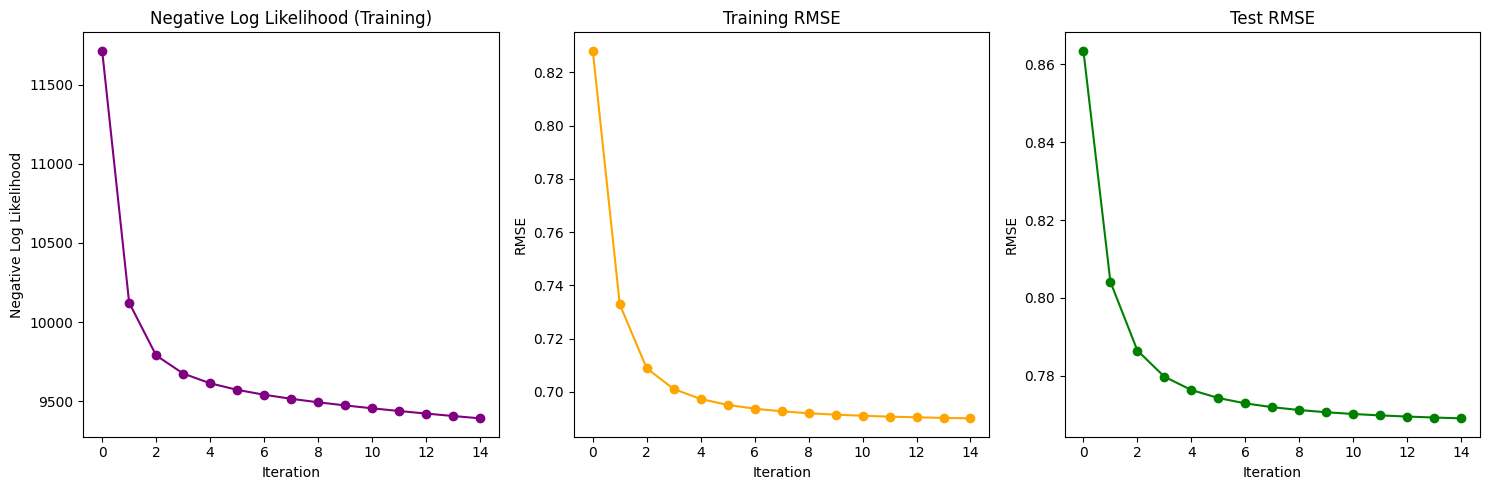


TRAINING COMPLETE (NUMBA OPTIMIZED)
Final Train RMSE: 0.6900
Final Test RMSE: 0.7691


In [9]:
# =============================================================================
# CELL 3: Replace the "Trying to vectorise training" cell with this code
# =============================================================================

# HYPERPARAMETERS

K = 32               # Number of latent factors
num_iters = 15       # Number of ALS iterations
lambda_reg = 0.001   # Regularization for latent factors (U, V)
tau = 0.05           # Regularization term for user/item vectors
gamma = 0.001        # Regularization for biases

M = n_users          # Number of users
N = n_movies         # Number of movies

print("\n" + "="*70)
print("INITIALIZING ALS MODEL (NUMBA OPTIMIZED)")
print("="*70)
print(f"Users: {M:,}")
print(f"Movies: {N:,}")
print(f"Latent factors (K): {K}")
print(f"Iterations: {num_iters}")
print(f"λ (lambda_reg): {lambda_reg}")
print(f"τ (tau): {tau}")
print(f"γ (gamma): {gamma}")

# INITIALIZE BIASES AND LATENT FACTORS

user_biases = np.zeros(M, dtype=np.float32)
item_biases = np.zeros(N, dtype=np.float32)
U = ((1/math.sqrt(K)) * np.random.randn(M, K)).astype(np.float32)   # User latent factors
V = ((1/math.sqrt(K)) * np.random.randn(N, K)).astype(np.float32)   # Item latent factors

# For plotting
nll_history = []
rmse_train_history = []
rmse_test_history = []

# ALS TRAINING LOOP (NUMBA OPTIMIZED)

print("\n" + "="*70)
print("TRAINING (NUMBA OPTIMIZED)")
print("="*70)
print("Note: First iteration may be slower due to JIT compilation...")

import time

for iter in range(num_iters):
    iter_start = time.time()

    # UPDATE ALL USERS (PARALLEL)
    update_all_users_numba(
        M, K, lambda_reg, tau, gamma,
        user_biases, item_biases, U, V,
        train_ratings_by_user,
        user_train_start
    )

    # UPDATE ALL ITEMS (PARALLEL)
    update_all_items_numba(
        N, K, lambda_reg, tau, gamma,
        user_biases, item_biases, U, V,
        train_ratings_by_movie,
        movie_train_start
    )

    # COMPUTE TRAINING METRICS (PARALLEL)
    squared_error, count = compute_train_metrics_numba(
        M, K,
        user_biases, item_biases, U, V,
        train_ratings_by_user,
        user_train_start
    )

    # Regularization terms
    reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
    reg_factors = np.sum(U ** 2) + np.sum(V ** 2)

    # Log likelihood formula from slides
    log_likelihood = -(lambda_reg / 2) * squared_error - (tau / 2) * reg_factors - (gamma / 2) * reg_bias

    # Negative log likelihood (negate to get NLL)
    nll = -log_likelihood
    nll_history.append(nll)

    # Training RMSE
    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)

    # COMPUTE TEST RMSE (PARALLEL)
    squared_error_test, count_test = compute_test_rmse_numba(
        M, K,
        user_biases, item_biases, U, V,
        test_ratings_by_user,
        user_test_start
    )

    rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else 0
    rmse_test_history.append(rmse_test)

    iter_time = time.time() - iter_start

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"NLL = {nll:.2f}, Time = {iter_time:.2f}s")

# PLOT RESULTS

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(nll_history, marker='o', color='purple')
plt.title("Negative Log Likelihood (Training)")
plt.xlabel("Iteration")
plt.ylabel("Negative Log Likelihood")

plt.subplot(1,3,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.title("Training RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("TRAINING COMPLETE (NUMBA OPTIMIZED)")
print("="*70)
print(f"Final Train RMSE: {rmse_train_history[-1]:.4f}")
print(f"Final Test RMSE: {rmse_test_history[-1]:.4f}")

### Test with dummy user

In [10]:
# helper function for movie name from movie_id

import pandas as pd

movies = pd.read_csv("ml-32m/movies.csv")

def get_movie_name(movie_id):
    row = movies[movies["movieId"] == movie_id]
    return row.iloc[0]["title"]

In [14]:
# DUMMY USER SETUP

print("\n" + "="*70)
print("CREATING DUMMY USER FOR RECOMMENDATIONS")
print("="*70)

# Harry Potter movie (you can change this to any movie_id)
harry_potter_movie_id = 2
rating_value = 5.0

# Get the movie index

harry_potter_idx = data.movie_id_to_idx[harry_potter_movie_id]
print(f"Movie ID: {harry_potter_movie_id}")
print(f"Movie Index: {harry_potter_idx}")
print(f"Rating: {rating_value}")

# Dummy user's ratings: [(movie_idx, rating)]
dummy_user_ratings = [(harry_potter_idx, rating_value)]

# TRAIN DUMMY USER (3 ITERATIONS)

print("\n" + "="*70)
print("TRAINING DUMMY USER")
print("="*70)

# Initialize dummy user's parameters
dummy_user_bias = 0.0
dummy_user_latent = np.zeros(K, dtype=np.float32)

num_dummy_iters = 3

for iter in range(num_dummy_iters):
    # Update dummy user bias
    bias_sum = 0
    for movie_idx, rating in dummy_user_ratings:
        pred = item_biases[movie_idx] + np.dot(dummy_user_latent, V[movie_idx])
        residual = rating - pred
        bias_sum += lambda_reg * residual

    dummy_user_bias = bias_sum / (lambda_reg * len(dummy_user_ratings) + gamma)

    # Update dummy user latent vector
    A = np.zeros((K, K), dtype=np.float32)
    b = np.zeros(K, dtype=np.float32)

    for movie_idx, rating in dummy_user_ratings:
        residual = rating - dummy_user_bias - item_biases[movie_idx]

        A += lambda_reg * np.outer(V[movie_idx], V[movie_idx])
        b += lambda_reg * residual * V[movie_idx]

    A += tau * np.eye(K, dtype=np.float32)
    dummy_user_latent = np.linalg.solve(A, b)

    print(f"Iteration {iter+1}/{num_dummy_iters}: bias = {dummy_user_bias:.4f}")

print(f"✓ Dummy user trained!")
print(f"  Final bias: {dummy_user_bias:.4f}")
print(f"  Latent vector norm: {np.linalg.norm(dummy_user_latent):.4f}")


CREATING DUMMY USER FOR RECOMMENDATIONS
Movie ID: 2
Movie Index: 1
Rating: 5.0

TRAINING DUMMY USER
Iteration 1/3: bias = 2.5284
Iteration 2/3: bias = 2.1547
Iteration 3/3: bias = 2.0994
✓ Dummy user trained!
  Final bias: 2.0994
  Latent vector norm: 0.1908


In [12]:
# COMPUTE RECOMMENDATION SCORES

print("\n" + "="*70)
print("COMPUTING RECOMMENDATION SCORES")
print("="*70)

# Compute scores for all movies
scores = np.zeros(N, dtype=np.float32)

for n in range(N):
    # Downweight item bias for better personalization
    scores[n] = np.dot(dummy_user_latent, V[n]) + 0.05 * item_biases[n]

# FILTER OUT LOW-RATED MOVIES

print("Filtering movies with fewer than 100 ratings...")

# Count ratings per movie in training set
movie_rating_counts = np.zeros(N, dtype=np.int32)
for n in range(N):
    movie_rating_counts[n] = movie_train_start[n+1] - movie_train_start[n]

# Create mask for movies with >= 100 ratings
popular_movies_mask = movie_rating_counts >= 100
num_popular = np.sum(popular_movies_mask)

print(f"Movies with >= 100 ratings: {num_popular:,}/{N:,}")

# Set scores of unpopular movies to (-inf) so they don't appear in recommendations
filtered_scores = scores.copy()
filtered_scores[~popular_movies_mask] = -np.inf

# GET TOP RECOMMENDATIONS

print("\n" + "="*70)
print("TOP 20 RECOMMENDATIONS")
print("="*70)

# Get top 20 movie indices
filtered_scores[harry_potter_idx] = -np.inf  # Don't recommend the movie they already rated

top_indices = np.argsort(filtered_scores)[::-1][:20]

print(f"\n{'Rank':<6} {'Movie ID':<12} {'# Movie Title':<12}")
print("-" * 50)

for rank, movie_idx in enumerate(top_indices, 1):
    movie_id = data.idx_to_movie_id[movie_idx]
    movie_name = get_movie_name(movie_id)
#   score = filtered_scores[movie_idx]
#   num_ratings = movie_rating_counts[movie_idx]
    print(f"{rank:<6} {movie_id:<12} {movie_name:}")



COMPUTING RECOMMENDATION SCORES
Filtering movies with fewer than 100 ratings...
Movies with >= 100 ratings: 11,732/84,432

TOP 20 RECOMMENDATIONS

Rank   Movie ID     # Movie Title
--------------------------------------------------
1      3114         Toy Story 2 (1999)
2      4886         Monsters, Inc. (2001)
3      6377         Finding Nemo (2003)
4      78499        Toy Story 3 (2010)
5      8961         Incredibles, The (2004)
6      364          Lion King, The (1994)
7      4306         Shrek (2001)
8      588          Aladdin (1992)
9      2355         Bug's Life, A (1998)
10     356          Forrest Gump (1994)
11     68954        Up (2009)
12     480          Jurassic Park (1993)
13     595          Beauty and the Beast (1991)
14     134853       Inside Out (2015)
15     34           Babe (1995)
16     8360         Shrek 2 (2004)
17     50872        Ratatouille (2007)
18     2028         Saving Private Ryan (1998)
19     2081         Little Mermaid, The (1989)
20     60069   

### Saving Model Parameters Locally

In [13]:
import pickle

with open('users_latent.pkl', 'wb') as file:
    pickle.dump(U, file)
with open('movies_latent.pkl', 'wb') as file:
    pickle.dump(V, file)
with open('users_biases.pkl', 'wb') as file:
    pickle.dump(user_biases, file)
with open('movies_biases.pkl', 'wb') as file:
    pickle.dump(item_biases, file)


## Finding Most Polarizing Movies

In [ ]:
# 1. Count ratings per movie
movie_rating_counts = np.zeros(N, dtype=int)
for movie_idx in range(N):
    start = movie_train_start[movie_idx]
    end = movie_train_start[movie_idx + 1]
    movie_rating_counts[movie_idx] = end - start

# 2. Helper
def has_enough_ratings(movie_idx, min_ratings=20):
    return movie_rating_counts[movie_idx] >= min_ratings

# 3. Norms
movie_norms = np.linalg.norm(V, axis=1)
sorted_desc = np.argsort(-movie_norms)   # descending
top_10 = []

for movie_idx in sorted_desc:
    if has_enough_ratings(movie_idx):
        movie_id = data.idx_to_movie_id[movie_idx]
        title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        top_10.append((title, movie_id, movie_norms[movie_idx]))
        if len(top_10) == 10:
            break

print("\n=== TOP 10 MOST POLARIZING MOVIES ===")
for title, movie_id, norm in top_10:
    print(f"{title:60s} | ID={movie_id:6d} | norm={norm:.4f}")

sorted_asc = np.argsort(movie_norms)   # ascending
bottom_10 = []

for movie_idx in sorted_asc:
    if has_enough_ratings(movie_idx):
        movie_id = data.idx_to_movie_id[movie_idx]
        title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        bottom_10.append((title, movie_id, movie_norms[movie_idx]))
        if len(bottom_10) == 10:
            break

print("\n=== BOTTOM 10 LEAST POLARIZING MOVIES ===")
for title, movie_id, norm in bottom_10:
    print(f"{title:60s} | ID={movie_id:6d} | norm={norm:.4f}")


In [ ]:
# Helper function: get ratings for a movie
def get_movie_train_ratings_array(movie_idx):
    """Return all training ratings for a movie as a numpy array"""
    ratings = get_movie_train_ratings(movie_idx)[:, 1]  # column 1 = rating
    return ratings

# Compute rating variance for each movie
movie_rating_var = np.zeros(N, dtype=np.float32)
min_ratings = 20  # filter out unpopular movies

for movie_idx in range(N):
    ratings = get_movie_train_ratings_array(movie_idx)
    if len(ratings) >= min_ratings:
        movie_rating_var[movie_idx] = np.var(ratings)
    else:
        movie_rating_var[movie_idx] = -1  # ignore movies with too few ratings

# Top 10 polarizing movies
top_10_idx = np.argsort(-movie_rating_var)[:10]

print("\n=== TOP 10 POLARIZING MOVIES ===")
for idx in top_10_idx:
    movie_id = data.idx_to_movie_id[idx]
    title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
    var = movie_rating_var[idx]
    print(f"{title:60s} | movieId={movie_id:6d} | rating variance={var:.4f}")

# Bottom 10 least polarizing movies
bottom_10_idx = np.argsort(movie_rating_var)[:10]

print("\n=== BOTTOM 10 LEAST POLARIZING MOVIES ===")
for idx in bottom_10_idx:
    movie_id = data.idx_to_movie_id[idx]
    title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
    var = movie_rating_var[idx]
    print(f"{title:60s} | movieId={movie_id:6d} | rating variance={var:.4f}")


In [ ]:
# Correct if movies are rows
movie_norms = np.linalg.norm(V, axis=1)

# Correct if movies are columns
movie_norms = np.linalg.norm(V, axis=0)


In [ ]:
for idx, movie_id in enumerate([259351]):
    print(movie_id, np.linalg.norm(V[idx]))

In [ ]:
movie_id = 356
movie_idx = data.movie_id_to_idx[movie_id]
norm_144436 = movie_norms[movie_idx]
print("Norm for movieId 144436:", norm_144436)

In [ ]:
title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
print(f"{title} (movieId={movie_id}) has norm = {norm_144436:.6f}")

In [ ]:
# %matplotlib inline

def plot_movie_embeddings(movie_ids, movies_latent, movies_biases, movie_to_idx, movies_df):
    """
    Plots 2D embeddings of selected movies, scaled by movie biases.

    Parameters:
        movie_ids (list): List of movie IDs to plot
        movies_latent (np.ndarray): Latent matrix V, shape (n_movies, k)
        movies_biases (np.ndarray): Movie biases, shape (n_movies,)
        movie_to_idx (dict): Mapping from movieId to row index in movies_latent
        movies_df (pd.DataFrame): Movies dataframe with "movieId" and "title"
    """
    # Extract latent vectors and biases
    selected_vectors = np.array([movies_latent[movie_to_idx[movie_id], :] for movie_id in movie_ids])
    selected_biases = np.array([movies_biases[movie_to_idx[movie_id]] for movie_id in movie_ids])

    # Scale vectors to highlight movies with higher bias
    scaled_vectors = selected_vectors * (1 + 0.05 * selected_biases[:, np.newaxis])

    plt.figure(figsize=(20, 10))

    for i, movie_id in enumerate(movie_ids):
        title = movies_df.loc[movies_df["movieId"] == movie_id, "title"].iloc[0]
        x, y = scaled_vectors[i, 0], scaled_vectors[i, 1]
        plt.scatter(x, y, s=100, label=title)
        plt.text(x + 0.01, y + 0.01, title, fontsize=9)  # offset for clarity

    plt.title("2D Embeddings of Selected Movies (Scaled by Bias)")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.legend(loc="upper left", fontsize="small", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig("2d_embeddings.svg")
    plt.show()


# Example movie IDs
movie_ids = [78772, 72407, 91104, 8957,8368,364, 48, 588, 1022,207027,167780, 1688, 131739, 140115,1907, 5816, 40815, 595, 7153, 4993, 1,  39446, 48877, 55577]
plot_movie_embeddings(movie_ids, V, item_biases, data.movie_id_to_idx, movies)


def plot_movie_embeddings(movie_ids, movies_latent, movies_biases, movie_to_idx, movies_df):
    """

### 2D Vector Embeddings

In [ ]:
from sklearn.decomposition import PCA

# Ensure inline plotting
%matplotlib inline

def plot_movie_embeddings_pca(movie_ids, movies_latent, movies_biases, movie_to_idx, movies_df):
    """
    Reduces latent dimensions to 2D using PCA and plots movie embeddings.

    Parameters:
        movie_ids (list): Movie IDs to visualize
        movies_latent (np.ndarray): Latent matrix V (n_movies × k)
        movies_biases (np.ndarray): Movie bias vector (n_movies,)
        movie_to_idx (dict): Mapping from movieId -> row index in latent matrix
        movies_df (pd.DataFrame): Movies dataframe (movieId, title)
    """

    # ---- 1. PCA on full latent matrix ----
    pca = PCA(n_components=2)
    V_2d = pca.fit_transform(movies_latent)   # shape (n_movies, 2)

    # ---- 2. Extract embeddings for selected movies ----
    x_vals = []
    y_vals = []
    titles = []

    for movie_id in movie_ids:
        idx = movie_to_idx[movie_id]
        x_vals.append(V_2d[idx, 0])
        y_vals.append(V_2d[idx, 1])
        titles.append(movies_df.loc[movies_df["movieId"] == movie_id, "title"].iloc[0])

    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)

    # ---- 3. Scaling points by bias (optional but cool) ----
    selected_biases = np.array([movies_biases[movie_to_idx[m]] for m in movie_ids])
    scale = 1 + 0.05 * selected_biases  # small bias-based scaling

    # ---- 4. Plot ----
    plt.figure(figsize=(22, 12))

    for i, title in enumerate(titles):
        plt.scatter(x_vals[i], y_vals[i], s=120 * scale[i], alpha=0.8)
        plt.text(x_vals[i] + 0.01, y_vals[i] + 0.01, title, fontsize=9)

    plt.title("Movie Embeddings (PCA Reduction to 2D)", fontsize=16)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.tight_layout()
#    Optional: save (MOVED BEFORE plt.show())
    plt.savefig("movie_embeddings_pca.svg", format="svg")

    plt.show() # <--- Now display the plotPhilipp


In [ ]:
"""movie_ids = [
    78772, 72407, 91104, 8957, 8368,
    364, 48, 588, 1022, 207027,
    167780, 1688, 131739, 140115, 1907,
    5816, 40815, 595, 7153, 4993,
    1, 39446, 48877, 55577
]"""
movie_ids = [78772, 72407,1, 78499,3114, 91104, 98203, 8957, 39446, 48877, 55577]

plot_movie_embeddings_pca(
    movie_ids,
    V,
    item_biases,
    data.movie_id_to_idx,
    movies
)
